In [6]:
import os
import numpy as np 
import pandas as pd
from scipy import stats, signal, io
import mne
import pickle
from mne import create_info, EpochsArray
from mne.time_frequency import tfr_morlet
from bids import BIDSLayout
import mne_bids
import scipy
import json
import IO
from sklearn import linear_model
from sklearn import linear_model, metrics
import multiprocessing
from sklearn.model_selection import cross_val_score
from sklearn import ensemble, model_selection
from matplotlib import pyplot as plt
import matplotlib 
from collections import OrderedDict

def get_int_runs(subject_id, subfolder):
    """
    :param patient_idx:
    :return: list with all run files for the given patient
    """
    os.listdir(settings['out_path'])

    if 'right' in str(subfolder):
        list_subject = [i for i in os.listdir(settings['out_path']) if i.startswith('sub_'+subject_id+'_sess_right') and i.endswith('.p')]
    else:
        list_subject = [i for i in os.listdir(settings['out_path']) if i.startswith('sub_'+subject_id+'_sess_left') and i.endswith('.p')]

    return list_subject

In [7]:
settings = {}
settings['frequencyranges']=[[4, 8], [8, 12], [13, 20], [20, 35], [13, 35], [60, 80], [90, 200], [60, 200]]
settings['seglengths']=[1, 2, 2, 3, 3, 3, 10, 10, 10]
settings['num_patients']=['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']
settings['BIDS_path'] = "C:\\Users\\ICN_admin\\Dropbox (Brain Modulation Lab)\\Shared Lab Folders\\CRCNS\\MOVEMENT DATA\\"
settings['out_path'] = "C:\\Users\\ICN_admin\\Dropbox (Brain Modulation Lab)\\Shared Lab Folders\\CRCNS\\MOVEMENT DATA\\derivatives\\Int_old_grid\\"
settings['out_path_process'] = "C:\\Users\\ICN_admin\\Dropbox (Brain Modulation Lab)\\Shared Lab Folders\\CRCNS\MOVEMENT DATA\\ECoG_STN\\LM_8fbands_nonCV\\"

In [8]:
# here: figure out the best channel from the LM_ind dataset, then plot the coefficient of a LM trained on that ch

In [9]:
def get_ind_weights(loc_="ECOG", mod_="CON"):
    res_ = np.zeros([11,8,10])
    for sub_idx in np.arange(0, len(settings['num_patients']), 1):
        sess  = [f for f in os.listdir(settings["out_path_process"]) if (loc_ in f) \
                 and settings["num_patients"][sub_idx] in f] 

        max_ = -1
        for sess_ in sess:
            dat = np.load(os.path.join(settings["out_path_process"], sess_), allow_pickle=True).tolist()

            if np.max(dat["score_te"][mod_]) > max_:
                max_ = np.max(dat["score_te"][mod_])
                argmax_ = np.argmax(dat["score_te"][mod_])
                X = dat["X"][:,argmax_, :]
                y = dat["y"][mod_][argmax_]
            for fband in range(8):
                for time_lag in range(10):
                    if time_lag == 0: 
                        X_ = X[:, fband] 
                    else:
                        X_ = X[:-time_lag, fband]
                    y_ = y[time_lag:]
                    res_[sub_idx, fband, time_lag] = \
                        linear_model.LinearRegression().fit(np.expand_dims(X_, axis=1), y_).coef_[0]
    return np.mean(np.array(res_), axis=0)

In [20]:
def plot_weights(arr, title_, cmap=False):
    plt.imshow(arr) #cmap='seismic')
    plt.clim(-0.04, 0.04)
    plt.xticks(np.arange(10), ['0', '-100', '-200', '-300', '-400', '-500', '-600', '-700', '-800', '-900'], 
              rotation=45, horizontalalignment = 'center')
    plt.yticks(np.arange(8), [r'$\theta$', r'$\alpha$', r'$l\beta$', r'$h\beta$', \
                             r'$a\beta$', r'$l\gamma$', r'$h\gamma$', r'$a\gamma$'])
    plt.xlabel('Time [ms]')
    plt.ylabel('Frequency Band')
    cbar = plt.colorbar()
    cbar.set_label('Weight')
    plt.xlim(-0.5, 9.5)
    plt.ylim(-0.5, 7.5)
    plt.gca().invert_xaxis()
    #plt.gca().invert_yaxis()
    plt.title(title_)

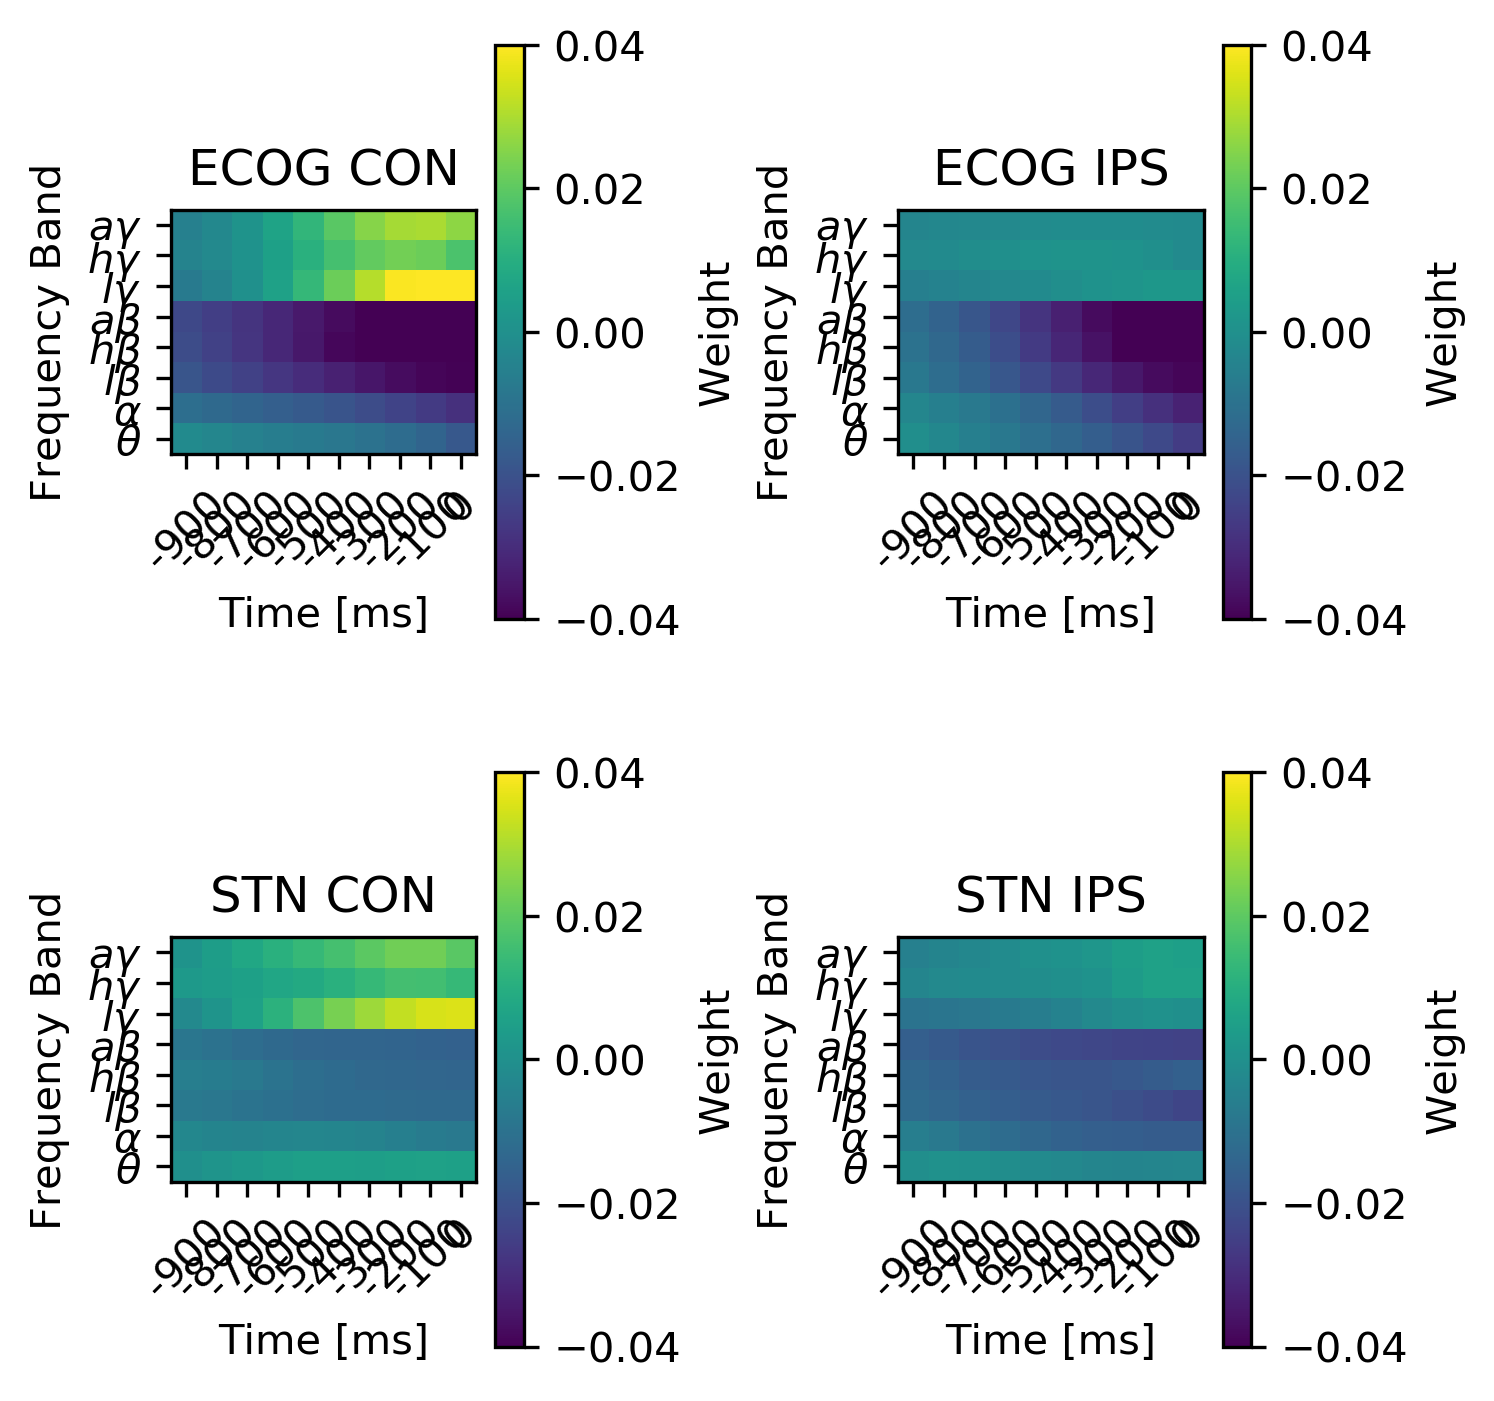

In [21]:
#plt.style.use('dark_background')
plt.figure(figsize=(5,5), dpi=300)
plt.subplot(2,2,1)
plot_weights(get_ind_weights(loc_="ECOG", mod_="CON"), 'ECOG CON')
plt.subplot(2,2,2)
plot_weights(get_ind_weights(loc_="ECOG", mod_="IPS"), 'ECOG IPS')
plt.subplot(2,2,3)
plot_weights(get_ind_weights(loc_="STN", mod_="CON"), 'STN CON')
plt.subplot(2,2,4)
plot_weights(get_ind_weights(loc_="STN", mod_="IPS"), 'STN IPS')
plt.tight_layout()

In [24]:
def plot_weights(arr, title_, cmap=False):
    plt.imshow(arr) #cmap='seismic')
    plt.clim(-0.04, 0.04)
    plt.xticks(np.arange(10), ['0', '-100', '-200', '-300', '-400', '-500', '-600', '-700', '-800', '-900'], 
              rotation=45, horizontalalignment = 'center')
    plt.yticks(np.arange(8), [r'$\theta$', r'$\alpha$', r'$l\beta$', r'$h\beta$', \
                             r'$a\beta$', r'$l\gamma$', r'$HFA$', r'$a\gamma$'])
    plt.xlabel('Time [ms]')
    plt.ylabel('Frequency Band')
    #cbar = plt.colorbar()
    #cbar.set_label('Weight')
    plt.xlim(-0.5, 9.5)
    plt.ylim(-0.5, 7.5)
    plt.gca().invert_xaxis()
    #plt.gca().invert_yaxis()
    plt.title(title_)

In [22]:
#plt.style.use('dark_background')
params = {'legend.fontsize': 'x-large',
          #'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

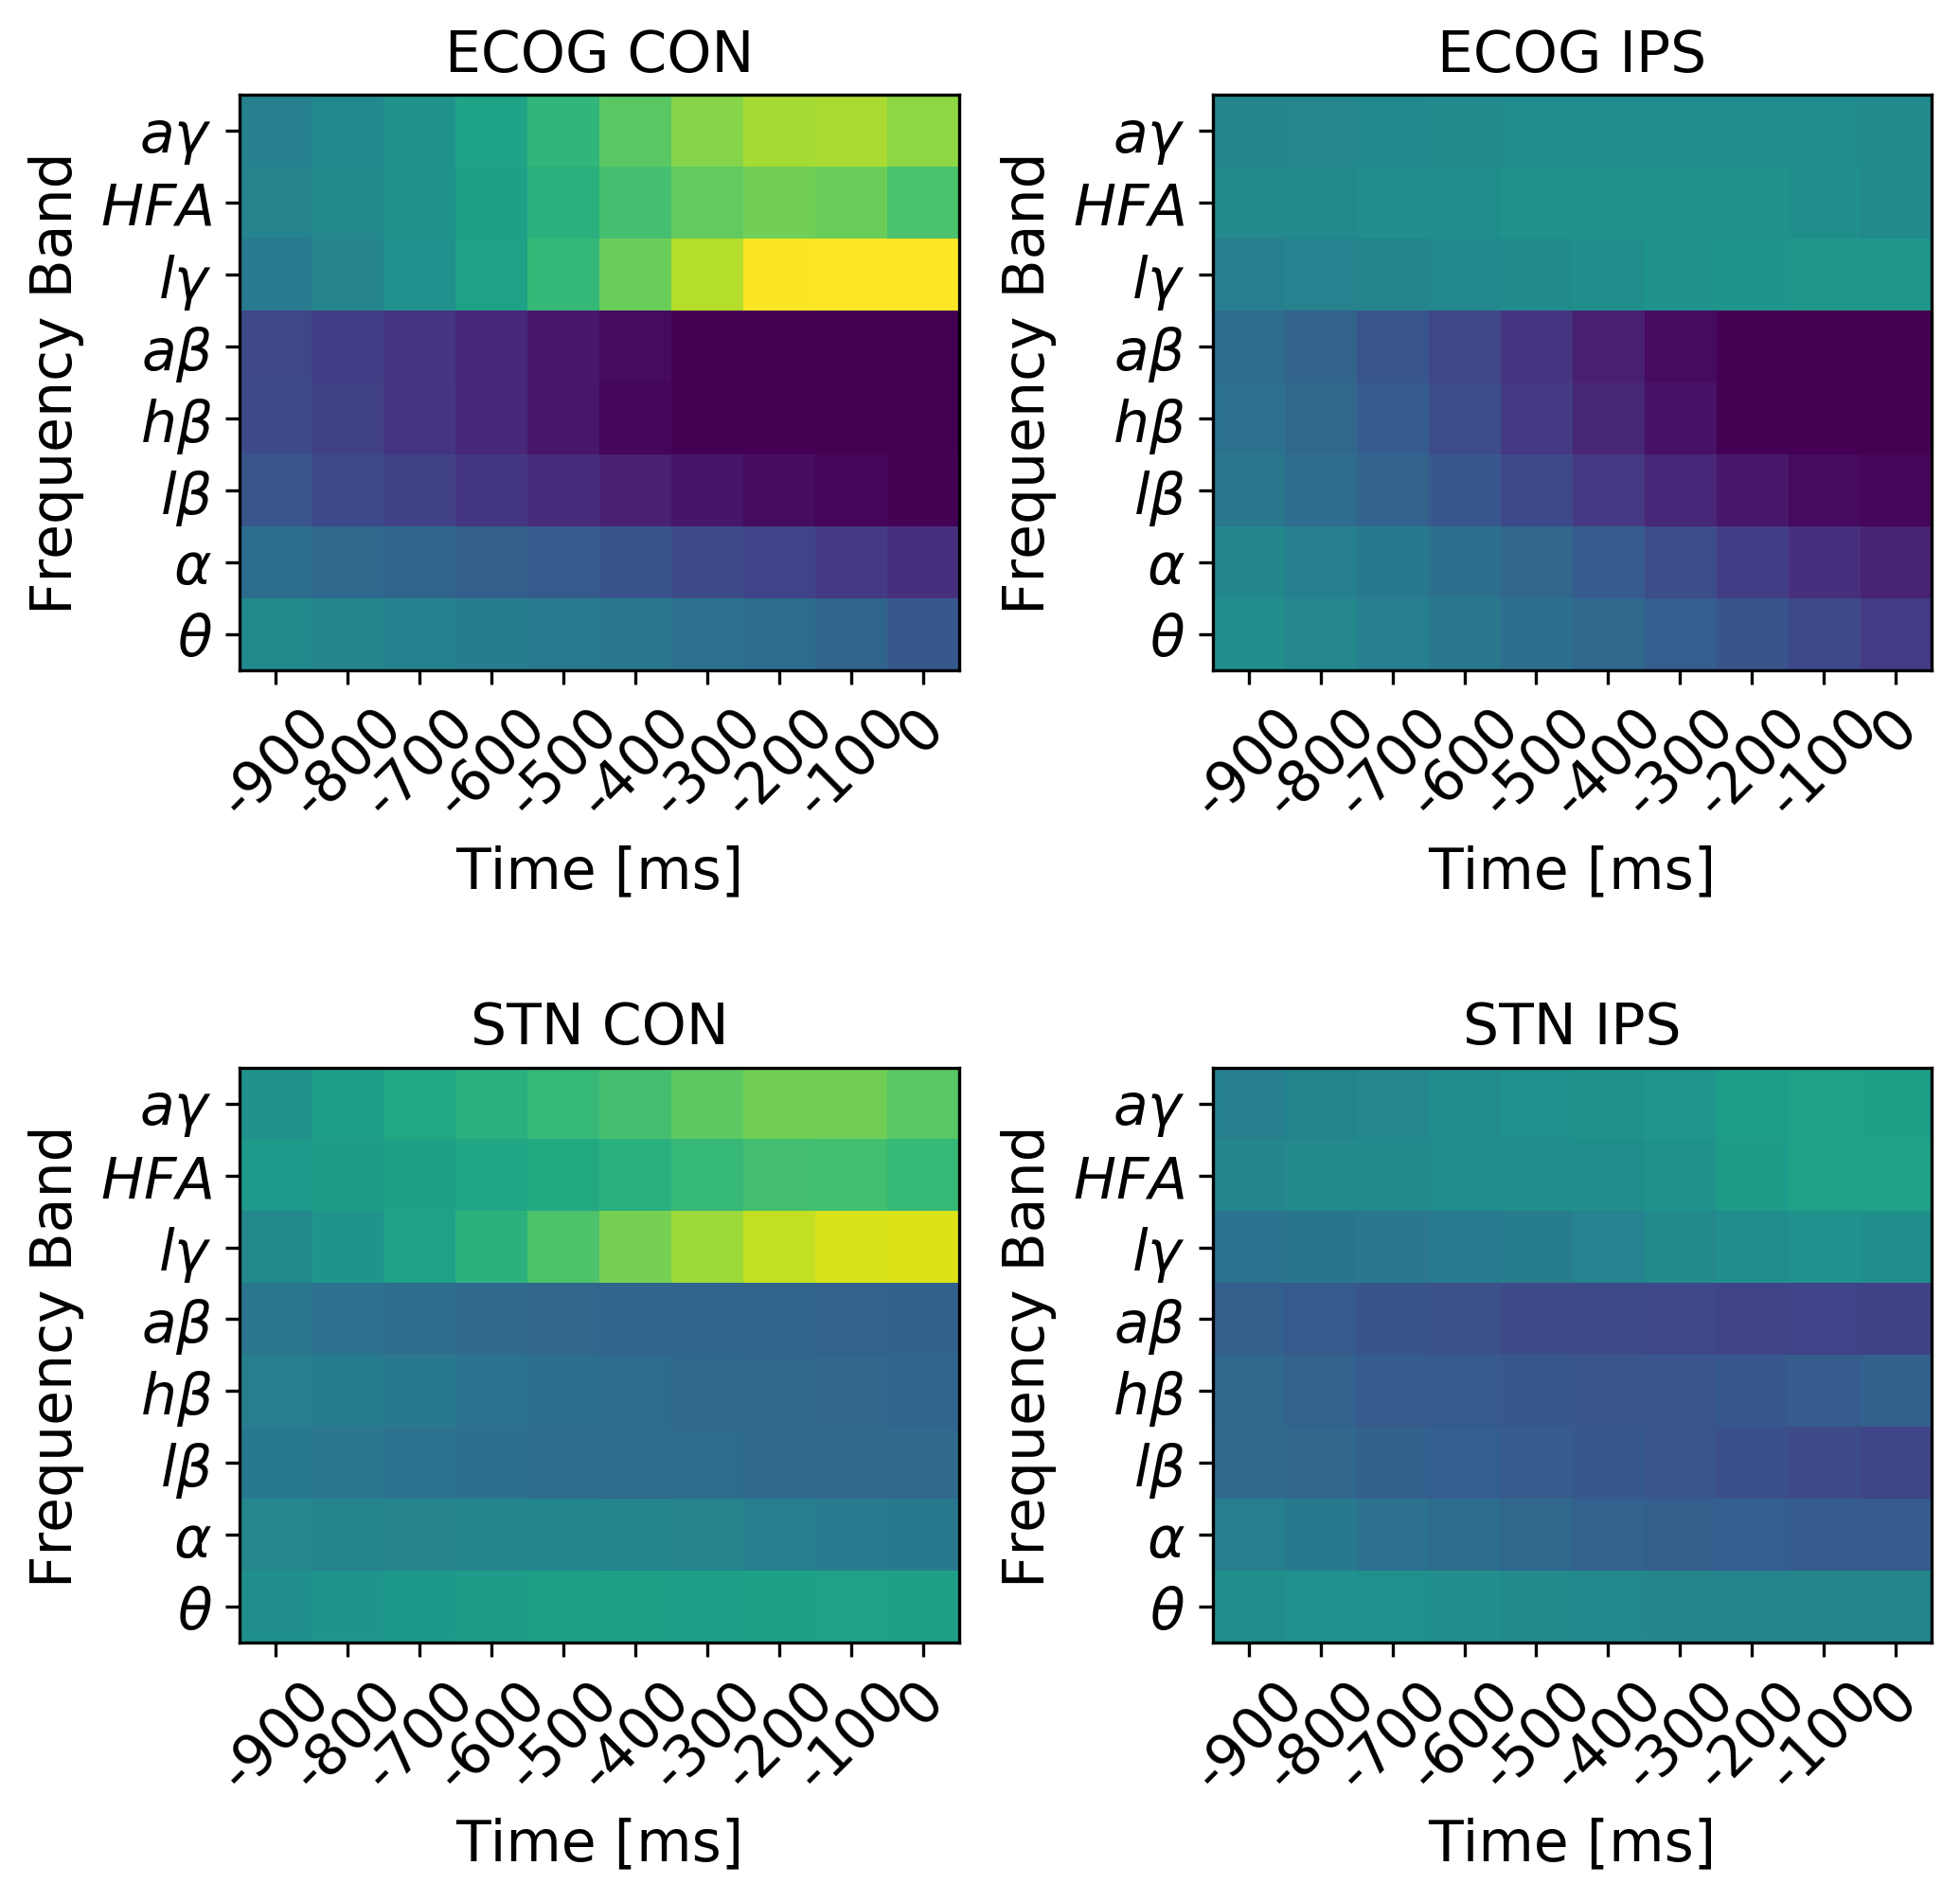

In [25]:
plt.figure(figsize=(7,7), dpi=300)
plt.subplot(2,2,1)
plot_weights(get_ind_weights(loc_="ECOG", mod_="CON"), 'ECOG CON')
plt.subplot(2,2,2)
plot_weights(get_ind_weights(loc_="ECOG", mod_="IPS"), 'ECOG IPS')
plt.subplot(2,2,3)
plot_weights(get_ind_weights(loc_="STN", mod_="CON"), 'STN CON')
plt.subplot(2,2,4)
plot_weights(get_ind_weights(loc_="STN", mod_="IPS"), 'STN IPS')
plt.tight_layout()